# Pandemic Flu Spread <br>
### Jonah Maroszek <br>

### Situation
Consider a classroom of **21 elementary school kids. 20 of the kids are healthy** (and susceptible to flu) on Day 1. Tommy (the 21st kid) walks in with the flu and starts interacting with his potential victims. <br>

To keep things simple, let’s suppose that **Tommy comes to school every day (whether or not he’s sick)** and will be infectious for **3 days** Thus, there are 3 chances for Tommy to infect the other kids — Days 1, 2, and 3. <br>

Suppose that the probability that he infects any individual susceptible kid on any of the three days is **p = 0.02**; and suppose that **all kids and days are independent** . <br>

**If a kid gets infected by Tommy, he will then become infectious for 3 days as well, starting on the next day.** <br>

## Assumptions <br>
<ul>
  <li>Each sick kid has the same chance of infecting healthy kids as tommy: 0.02</li>
  <li>Each kid gets sick for the same duration tommy does: 3 days </li>
  <li>Tommy is included in the count of sick kids (but not for counts involving infections) </li>
  <li> After a kid gets sick and recovers, they are not susceptible to infection again </li>
  <li> The simulation is over when no one is susceptable to infection or there are no sick kids to infect others  </li>
</ul>

# Simulation 
## Enter Simulation Parameters 


In [67]:
n_kids = 21 #including tommy
n_simulations = 10000
infection_rate = 0.02

## Imports

In [68]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass

## Define Classes for Kid and Classroom

In [69]:
@dataclass
class Kid:
    infectable: bool = True
    immune: int = False
    day_infected: int = None
    recovery_time: int = 3 

    #determine if kid is healthy, infected, or immune
    def check_up(self, day):
        if self.day_infected == None:
            return
        elif (day - self.day_infected) <= self.recovery_time: 
            self.infectable = False
        else:
            self.immune = True
            self.infectable = False
        
@dataclass
class Classroom:
    members: list[Kid]
    size: int = None
    n_infectable: int = None
    n_sick: int = None
    n_immune: int = None
    infection_rate: float = None

    def __post_init__(self):
        self.size = len(self.members)
        self.n_infectable = sum([1 if kid.infectable else 0 for kid in self.members])
        self.n_sick = self.size - self.get_n_infectable()
        self.n_immune = self.get_n_immune()
        self.infection_rate = self.get_infection_rate()

    def get_n_infectable(self):
        return sum([1 if kid.infectable else 0 for kid in self.members])
    
    def get_n_immune(self):
        return sum([1 if kid.immune else 0 for kid in self.members])
    
    def get_infection_rate(self):
        return min(self.n_sick * infection_rate, 1)
    
    def infect_kids(self, n_infect, day):
        for kid in self.members:
            if kid.infectable and n_infect > 0:
                kid.day_infected = day
                n_infect -= 1
            kid.check_up(day) #update kids health status 

    def update(self):
        self.n_infectable = sum([1 if kid.infectable else 0 for kid in self.members])
        self.n_sick = self.size - (self.get_n_infectable() + self.get_n_immune())
        self.n_immune = self.get_n_immune()
        self.infection_rate = self.get_infection_rate()

# Simulate Epidemics

In [70]:
def setup_classroom(n_kids):
    kids = [Kid() for i in range(n_kids - 1)]
    kids.append(Kid(infectable = False, day_infected=1)) #Tommy
    return Classroom(kids)

def run_epidemic(classroom):
    n_infectable_by_day = []
    n_infected_by_day = []
    n_sick_on_day = [] 
    n_immune_by_day =[]
    day = 0 
    while classroom.n_infectable > 0 and classroom.n_sick > 0: 
        n_infected = stats.binom.rvs(classroom.n_infectable, classroom.infection_rate)
        classroom.infect_kids(n_infected, day)
        classroom.update()
        n_infectable_by_day.append(classroom.n_infectable)
        n_infected_by_day.append(classroom.size - classroom.n_infectable)
        n_sick_on_day.append(classroom.n_sick)
        n_immune_by_day.append(classroom.n_immune)
        day += 1
    return {"n_infectable_by_day": n_infectable_by_day, 
            "n_infected_by_day": n_infected_by_day, 
            "n_sick_on_day": n_sick_on_day, 
            "n_immune_by_day": n_immune_by_day}

epidemics = []
for i in range(n_simulations):
    classroom = setup_classroom(n_kids)
    epidemic = run_epidemic(classroom)
    epidemics.append(epidemic)

# Distribution of Kids Infected on Day 1
We know  the exact distribution of kids that tommy infects on day 1 is Binomial(n=20, p=0.02). This gives us an expected number of infections of np = 0.4. The expected number of infections matches closely with the simulation results

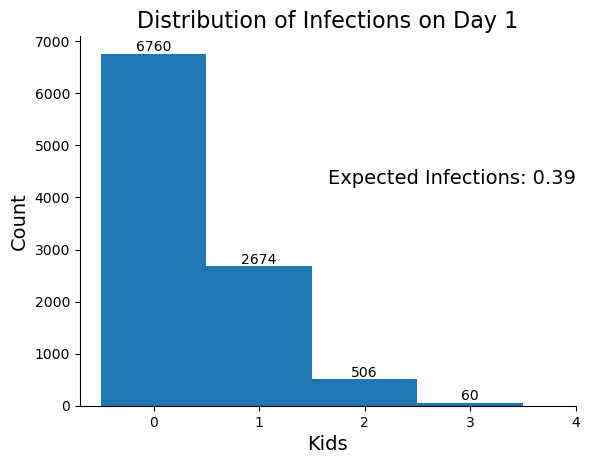

In [83]:
n_infected_day_1 = [epidemic['n_sick_on_day'][0] - 1 for epidemic in epidemics] #the count of sick kids includes tommy, so subtract 1
expected_sick_on_day_1 = np.mean(n_infected_day_1)

fig, ax = plt.subplots()
bins = np.arange(0, 5) 
counts, edges, bars = ax.hist(n_infected_day_1, bins, align='left')
ax.bar_label(bars)
ax.set_xlabel("Kids", size = 14)
ax.set_ylabel("Count", size = 14)
ax.set_title("Distribution of Infections on Day 1", size = 16)
ax.spines[['right', 'top']].set_visible(False)
ax.set_xticks(bins)
_ = ax.annotate(f"Expected Infections: {np.round(expected_sick_on_day_1, 2)}", xy=(0.5, .6), xycoords="axes fraction", size = 14) 
plt.savefig("day 1 distribution.png")

# Distribution of Kids Infected by Day 2
Note that since the recovery period is 3 days for each student, all kids infected on day 1 will still be sick on day 2. Tommy will also be sick, but he is not included in the count here. 

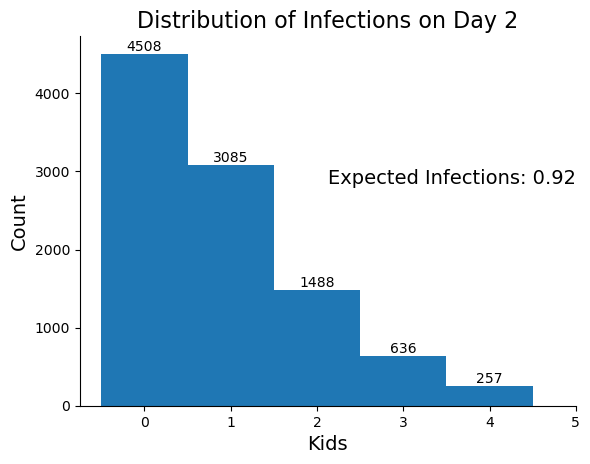

In [82]:
n_infected_day_2 = [epidemic['n_sick_on_day'][1] - 1 for epidemic in epidemics] #the count of sick kids includes tommy, so subtract 1
expected_sick_on_day_2 = np.mean(n_infected_day_2)

fig, ax = plt.subplots()
bins = np.arange(0, 6) 
counts, edges, bars = ax.hist(n_infected_day_2, bins, align='left')
ax.bar_label(bars)
ax.set_xlabel("Kids", size = 14)
ax.set_ylabel("Count", size = 14)
ax.set_title("Distribution of Infections on Day 2", size = 16)
ax.spines[['right', 'top']].set_visible(False)
ax.set_xticks(bins)
_ = ax.annotate(f"Expected Infections: {np.round(expected_sick_on_day_2, 2)}", xy=(0.5, .6), xycoords="axes fraction", size = 14) 
plt.savefig("day 2 distribution.png")

# Expected Infections for the First 20 Days
Note this is a cummulative sum of all students that have been infected by day i, even those that have been infected and recovered by day i.

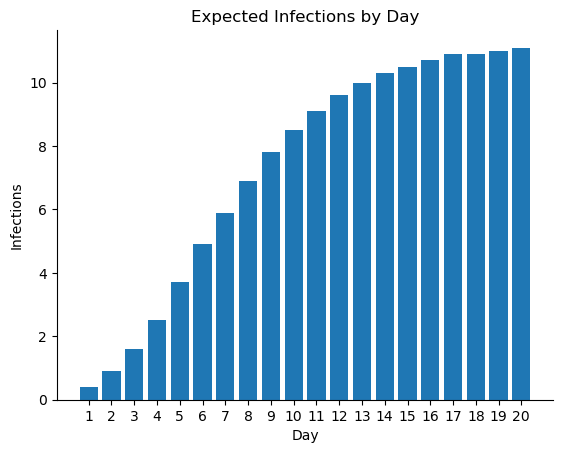

In [73]:
expected_infections_by_day = []
days = 20
for i in range(days):
    infected_by_day_i = []
    for epidemic in epidemics:
        if i <= len(epidemic['n_infected_by_day']) - 1:
            infected_by_day_i.append(epidemic['n_infected_by_day'][i] - 1) #exclude tommy from infection count
        else: 
            infected_by_day_i.append(epidemic['n_infected_by_day'][-1] - 1)  
    expected_infections_by_day.append(np.mean(infected_by_day_i))
    
fig, ax = plt.subplots()
locations = [x + 1 for x in range(days)] 
bars = ax.bar(locations, np.round(expected_infections_by_day, 1))
#_ = ax.bar_label(bars) #uncomment if less than 10 days for bar labels
ax.set_xlabel("Day")
ax.set_ylabel("Infections")
ax.set_title("Expected Infections by Day")
ax.spines[['right', 'top']].set_visible(False)
_ = ax.set_xticks(locations)
plt.savefig("mean inf by day.png")

# How Long will the Epidemic Last?

39


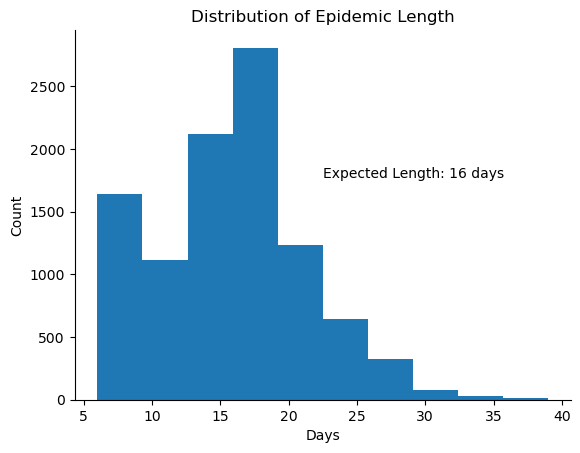

In [74]:
epidemic_len = [len(epidemic["n_sick_on_day"]) for epidemic in epidemics]
expected_len = np.mean(epidemic_len)
fig, ax = plt.subplots()
ax.hist(epidemic_len)
ax.set_xlabel("Days")
ax.set_ylabel("Count")
ax.set_title("Distribution of Epidemic Length")
ax.spines[['right', 'top']].set_visible(False)
_ = ax.annotate(f"Expected Length: {expected_len:.0f} days", xy=(0.5, .6), xycoords="axes fraction") 
plt.savefig("pandemic length.png")
print(np.max(epidemic_len))